## Stack Overflow Analysis

We seek to answer the question posed in https://math.meta.stackexchange.com/q/21259/384342.

### Extract probability mass function of user scores

http://data.stackexchange.com/math/query/567390/number-of-users-with-reputation-n

### Pull that data into a pandas DF


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline


/Users/bob/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bob/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bob/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv(
    "http://data.stackexchange.com/math/csv/715124",
    names=['Reputation', 'UserCount'],
    dtype=float,
    skiprows=1)
df.head()

,Reputation,UserCount
0,1.0,215368.0
1,2.0,393.0
2,3.0,9897.0
3,4.0,2044.0
4,5.0,916.0


## Plot Results

Use `plt.loglog`

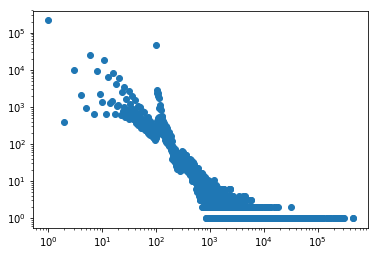

In [3]:
plt.loglog(df.Reputation, df.UserCount, 'o')

## Bin Scores

To find out if we have a power law we need to see if the log-log distribution function is linear.
If it is sub linear the tail is less heavy than a power law.

To do this, we need to bin the scores using the `pd.cut` function.

In [4]:
df['user_proportion'] = df.UserCount/sum(df.UserCount)


cut_points = np.power(10,np.arange(0,8,.1))
bins = pd.cut(df.Reputation,cut_points,right=False)
df2 = df.groupby(bins).user_proportion.sum().reset_index()


df2['cut_points'] = cut_points[:-1]
df2.dropna(inplace=True)
df2['log_reputation'] = np.log10(df2.cut_points)
df2['log_user_proportion'] = np.log10(df2.user_proportion)

df2 = df2.replace([np.inf, -np.inf], np.nan).dropna()
df2.head()

/Users/bob/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


,Reputation,user_proportion,cut_points,log_reputation,log_user_proportion
0,"[1.0, 1.259)",0.471629,1.000000,0.0,-0.326399
3,"[1.995, 2.512)",0.000861,1.995262,0.3,-3.065188
4,"[2.512, 3.162)",0.021673,2.511886,0.4,-1.664077
6,"[3.981, 5.012)",0.006482,3.981072,0.6,-2.188289
7,"[5.012, 6.31)",0.054337,5.011872,0.7,-1.264901


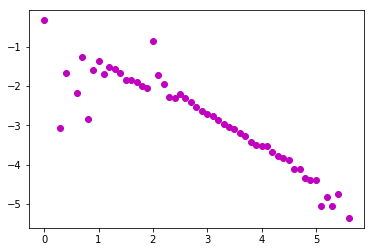

In [5]:

plt.plot(df2.log_reputation, df2.log_user_proportion, 'mo')

## Fit a line

Use https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html


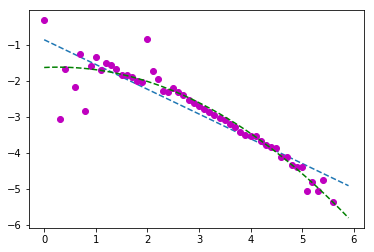

In [6]:
poly_coeffs = np.polyfit(df2.log_reputation, df2.log_user_proportion, 1)
poly_1 = np.poly1d(poly_coeffs)
x_vals = np.arange(0, 6, .1)
plt.plot(x_vals, poly_1(x_vals), '--')
plt.plot(df2.log_reputation, df2.log_user_proportion, 'mo')

# fit a quadratic
poly_coeffs = np.polyfit(df2.log_reputation, df2.log_user_proportion, 2)
poly_2 = np.poly1d(poly_coeffs)
plt.plot(x_vals, poly_2(x_vals), 'g--')

## Repeat with all of SO

https://data.stackexchange.com/stackoverflow/csv/715082


## Putting it all together

See discussion at http://rjbaxley.com/posts/2016/11/08/Stack_Exchange_Reputation_Power_Law.html

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

def plot_hist(df,alpha,c,label, ax=None, limits = [-1,7,-8,1], trends=False):

    ax = df.plot(x='log_reputation',
                 y=['log_user_proportion'],
                 kind='scatter',
                 alpha=alpha,
                 ax=ax,
                 color=c,edgecolor=c,
                label=label,
                figsize=(15.0, 10.0))
    if trends:
        X = df.log_reputation
        X = sm.add_constant(X)
        model = sm.OLS(df.log_user_proportion, X)
        results = model.fit()
        df['linear_trend'] = results.fittedvalues
        plt.text(df.log_reputation.min(),df.linear_trend.max(),
                 '{log_reputation:10.4f}x +{const:10.4f}'.format(**results.params)+
                '\nr**2 = {}'.format(results.rsquared))

        X = np.column_stack((df.log_reputation, df.log_reputation**2))
        X = sm.add_constant(X)
        model = sm.OLS(df.log_user_proportion, X)
        results = model.fit()
        df['quad_trend'] = results.fittedvalues

        plt.text(3,-2,
                 '{x2:10.4f}x**2 +{x1:10.4f}x +{const:10.4f}'.format(**results.params)+
                '\nr**2 = {}'.format(results.rsquared))
        ax = df.plot(x='log_reputation',
                     y=['linear_trend','quad_trend'],
                     kind='line',
                     alpha=1,
                     ax=ax)
    plt.axis(limits)
    plt.grid(True)
    return ax


def process_df(url):
    df = pd.read_csv(url,names=['Reputation','UserCount'],dtype=float,skiprows=1)
    df['user_proportion'] = df.UserCount/sum(df.UserCount)
    df['log_user_proportion'] = np.log10(df.user_proportion)
    df['log_reputation'] = np.log10(df.Reputation)
    ax = plot_hist(df,.1,c='b',label='un-binned')


    cut_points = np.power(10,np.arange(0,8,.1))
    bins = pd.cut(df.Reputation,cut_points,right=False)
    df = df.groupby(bins).user_proportion.sum().reset_index()
    df['cut_points'] = cut_points[:-1]
    df.dropna(inplace=True)
    df['log_reputation'] = np.log10(df.cut_points)
    df['log_user_proportion'] = np.log10(df.user_proportion)
    
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    plot_hist(df,1,c='m',ax=ax,label='binned',trends=True)
    plt.legend()
    return df

df = process_df('http://data.stackexchange.com/math/csv/715124')
plt.title('Mathematics')
df2 = process_df('https://data.stackexchange.com/stackoverflow/csv/715082')
plt.title('Stack Overflow')